# [IceBridge Alaska](https://www.nasa.gov/image-feature/operation-icebridge-exploring-alaska-s-mountain-glaciers) Altimetry Analysis Tools

#### Code Developers: Anthony Arendt, Evan Burgess, Chris Larsen, Christian Kienholz

This code queries the data and shows how to do anaylsis and plots.

In [6]:
import yaml
import pandas as pd

import AltPy.Altimetry as alt
import AltPy.UpdateDb as updatedb

%matplotlib inline
from matplotlib.pyplot import *

In [7]:
credentials = yaml.load(open('../.env.yaml'), Loader=yaml.FullLoader)

### Altimetry.Altimetry.GetLambData(\*args,\**kwargs)

#### Purpose:
This is the primary function to extract Laser Altimetry Mass Balance (LAMB) data from the database. The key point to understand is that this code does not calculate mass balance from the raw LiDAR point clouds that are also stored in ice2oceans database. Instead, GetLambData queries a table called lamb that contains the surface elevation change profiles for each glacier over each possible interval.  Each profile in this table was generated using a semi-manual step (discussed in Arendt et al., (2002) and Johnson et all. (2013)), where a user defines a bin size, a glacier polygon etc and then runs a matlab script called 'lamb' to generate a top-bottom profile of surface elevation change rates.  This script also outputs the along profile IQR of the measured surface elevation change and the mass balance integrated across the user defined glacier polygon.  All of this data is included in the lamb table and output by GetLambData.  The only part of 'lamb' used by Larsen et al., is the elevation change rate profile and the IQR for each glacier. This script will retrieve Lambdata for any group of glaciers and survey intervals.  It contains keywords for you to filter what intervals you would like.  It will also return the glacier polygon from the RGI (the one used in Larsen et al., [2015] not Johnson et al. [2013]), the glacier hypsometry, and the Larsen et al., 2015 
mass balance estimate for that glacier.
    
#### Keyword Arguments:        
<dl>

<dt>removerepeats</dt><dd>Set to True to select only the shortest/non-overlapping intervals for each glacier. Set to false to include all data.  Default Value=True</dd>

<dt>longest_interval</dt><dd>Set to True to retreive only the single longest interval available for each glacier.</dd>

<dt>days_from_year</dt><dd>Set the number of days away from 365 to be considered.  For example if you want annual 
                    intervals to be within month of each other leave default of 30. If you want sub-annual 
                    (seasonal data) set to 365.  Default Value = 30</dd>

<dt>interval_min</dt><dd>Minimum length of interval in years. This is a rounded value so inputing 1 will include
                    an interval of 0.8 years if it passes the days_from_year threshold above. Default = 0 </dd>

<dt>interval_max</dt><dd>Maximum length of interval in years. This is a rounded value so inputing 3 will include
                    an interval of 3.1 years if it passes the days_from_year threshold  above. Default = None</dd>

<dt>earliest_date</dt><dd>Earliest date of first acquistion. Enter as string 'YYYY-MM-DD'. Default = None</dd>

<dt>latest_date</dt><dd>Latest date of second acquistion. Enter as string 'YYYY-MM-DD'. Default = None</dd>

<dt>userwhere</dt><dd>Enter as string.  User can input additional queries as a string to a where statement. Any fields in ergi_mat_view or lamb are valid. Example input:"name NOT LIKE '%Columbia%' AND area > 10". Default=""</dd> 

<dt>verbose</dt><dd>Verbose output. Default = True</dd>

<dt>get_geom</dt><dd>Set to True to retrieve the geometry of the glacier polygon</dd>

<dt>generalize</dt><dd>Set to a value to simplify geometries</dd>

<dt>by_column</dt><dd>Get data organized by column instead of by lamb file (Default=True)</dd>

<dt>as_object</dt><dd>Get data output as a LambObject.  Only works if by_column = True (Default=True)</dd>

<dt>get_glimsid</dt><dd>Set to true to retrieve each glaciers glimsid as well.</dd>

<dt>results</dt><dd>Set to true to retrieve the mass balance of the glacier as is estimated by Larsen et. al. (2015).  Note the larsen et al mass balance is returned regardless of the interval you chose for that glacier.</dd></dl>

#### Returns: 
A dictionary or a lamb object with all attributes available in lamb as well as glacier parameters
available in ergi_mat_view for the selection of surveyed glacier intervals chosen.
 
#### Example:

In [55]:
# Lets look at a timeseries of Tsina elevation change profiles

#Selecting all of the non-overlapping altimetry intervals available for Tsina
data = alt.GetLambData(credentials['ice2oceansdb-Altimetry-user'],userwhere="name = 'Tsina Glacier'") 


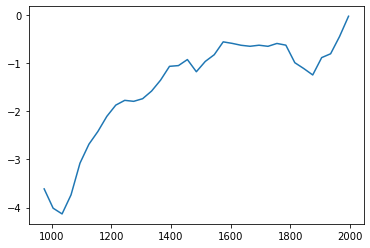

In [56]:
n=1
plot(data['e'][n],data['dz'][n])

### class   Altimetry.Altimetry.LambObject()

GetLambData can output data as a dictionary, as shown above, but it can also output the same data as an instance of a lamb object or a list of lamb objects.  This not only makes life easier syntactically, it also provides access to an assortment of important methods available to this object class.  Each lamb oject will contain attributes whose name and value correspond to matching fields in the database:

 Attribute     |   Data Type   |     Description
 ------------- |:-------------:|:-----
lambid |       integer | Primary Key
ergiid |       integer | foreign key to ergi
date1 |        date | First Acquisition Date
date2 |        date | Second Acquisition Date
interval |      smallint | Interval Length (days)
volmodel |        real | Gacier-wide mass balance in Gt/yr: not used for Larsen et al., [2015]
vol25diff |        real | Gacier-wide mass balance 25th percentile error estimate in Gt/yr: not used for Larsen et al., [2015]
vol75diff |        real | Gacier-wide mass balance 75th percentile error estimate in Gt/yr: not used for Larsen et al., [2015]
balmodel |        real | Gacier-wide mass balance in m w. e./yr: not used for Larsen et al., [2015]
bal25diff |        real | Gacier-wide mass balance 25th percentile error estimate in m w. e./yr: not used for Larsen et al., [2015]
bal75diff |        real | Gacier-wide mass balance 75th percentile error estimate in m w. e./yr: not used for Larsen et al., [2015]
e |       integer[] | Elevation of bottom of bin (m)
dz |        real[] | Surface elevation change rate along elevation profile specified by e (m/yr)
dz25 |        real[] | Surface elevation change rate variability: 25th percentile along elevation profile specified by e (m/yr)
dz75 |        real[] | Surface elevation change rate variability: 75th percentile along elevation profile specified by e (m/yr)
aad |        real[] | Area Altitude Distribution for the surveyed glacier determined using a polygon drawn by an UAF LiDAR altimetry tech and may/may not be the RGI polygon. Note this AAD was not used for Larsen et al. [2015].
masschange |        real[] | Lamb output: not used for Larsen et al., 2015 (units?)
massbal |        real[] | Lamb output: not used for Larsen et al., 2015 (units?)
numdata |       integer[] | Number of crossing points in Bin
ergiid |  integer | Primary key to ergi table
area |  numeric | Glacier Area
min |  numeric | Min elevation of the glacier defined by the RGI 4.0
max |  numeric | Max elevation of the glacier defined by the RGI 4.0
continentality |   real | Distance from coast (polygon centerpoint) units(?)
albersgeom | geometry(MultiPolygon,3338) | Alaska Albers Polygon Geometry of the glacier boundary
name |   character varying(45) | Glacier Name
gltype |  integer | Terminus Type 0=land,1=tide,2=lake
surge |  boolean | Surge-Type Glacier?
region |   character varying(50) | Region defined by Larsen et al., 2015 that this glacier is in
arendtregion |  integer | Region defined by Arendt et al., 2002 that this glacier is in



list


Text(0, 0.5, 'Elevation Change Rate (m/yr)')

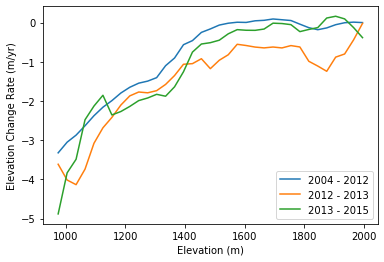

In [54]:
#Lets look at the Tsina timeseries
#Note the only thing different from above is as_object is set to 'True'
data = alt.GetLambData(credentials['ice2oceansdb-Altimetry-user'],removerepeats=True,by_column=False,as_object=True, userwhere="ergi_mat_view.name='Tsina Glacier'") 

#Plotting
for t in data:
    plot(t.e,t.dz,label="%s - %s" % (t.date1.year,t.date2.year))
legend(loc=4)
xlabel('Elevation (m)')
ylabel('Elevation Change Rate (m/yr)')